In [2]:
from glob import glob
import numpy as np
import scipy as sp
import json
import os
import matplotlib.pyplot as plt

os.chdir("../")


In [3]:
input_folder = "./data/tdoa_20201016/data/music_0014/"


def _read_input_folder(input_folder):

    n = len(glob(input_folder + "*.wav"))
    # info = json.load(open(input_folder + "/info.json",'r'))
    # n = info["number_of_mics"]

    sounds = []
    for i in range(n):
        fs, s = sp.io.wavfile.read(input_folder + "/Track " + str(i+1)+".wav")
        sounds.append(s)

    return_obj = np.zeros((n, len(sounds[0])))
    for i in range(n):
        return_obj[i] = sounds[i]

    return (fs, return_obj)


_read_input_folder(input_folder)


(96000,
 array([[-1946624., -2079744., -2043904., ...,        0.,        0.,
                0.],
        [-4788736., -5047552., -4610304., ...,        0.,        0.,
                0.],
        [  250112.,   139520.,  -232448., ...,        0.,        0.,
                0.],
        ...,
        [ 6407168.,  6902016.,  6766080., ...,        0.,        0.,
                0.],
        [-8608000., -8731904., -8423680., ...,        0.,        0.,
                0.],
        [-3149056., -2709248., -2435584., ...,        0.,        0.,
                0.]]))

In [11]:
from glob import glob
import numpy as np
import scipy as sp
import json

# constants

SPEED_OF_SOUND = 343

# Helper functions ----------------------------


def _read_input_folder(input_folder):

    n = len(glob(input_folder + "*.wav"))
    # info = json.load(open(input_folder + "/info.json",'r'))
    # n = info["number_of_mics"]

    sounds = []
    for i in range(n):
        fs, s = sp.io.wavfile.read(input_folder + "/Track " + str(i+1)+".wav")
        sounds.append(s)

    return_obj = np.zeros((n, len(sounds[0])))
    for i in range(n):
        return_obj[i] = sounds[i]

    return (fs, return_obj)


def _divide_into_tdoa_chunks(sounds, fs, chunk_length):
    """
    Divides sound into chunks of a given length, and matches with ground truth for tdoa

    Input : 
        sounds, numpy_array of size=(nmics, sound_length)
        fs, int; sampling frequency

    Output : 
        list((
            sounds, numpy_array of size=(nmics, chunk_length)
            time, float
                time since start of the original recording in seconds
            ))
    """

    problems = []
    starts = np.arange(0, sounds.shape[-1], chunk_length)[:-1]

    for start in starts:

        sound = sounds[:, start:(start+chunk_length)]
        time = (start + chunk_length/2)/fs
        problems.append((sound, time))
    return problems


def _gcc_phat(problem, highest_fft_component_to_throw=300):
    c = sp.fft.fft(problem[0])
    nmics = problem[0].shape[0]

    result = np.empty((nmics, nmics))
    for mic1 in range(problem[0].shape[0]):
        for mic2 in range(mic1+1, problem[0].shape[0]):
            temp = c[mic1, :]*np.conj(c[mic2, :])
            temp /= np.abs(temp) + 1e-10
            temp[highest_fft_component_to_throw:-
                 highest_fft_component_to_throw] = 0
            res = sp.fft.ifft(temp)

            bi = np.argmax(res)
            result[mic1, mic2] = bi if bi < problem[0].shape[1] / \
                2 else bi - problem[0].shape[1]
        result[mic2, mic1] = -result[mic1, mic2]

    return result


# Different detectors ----------------------------
def gcc_phat_detector(input_folder, output_folder=None, window_length=10000, speed_of_movement=0):
    """
    GCC-phat algorithm
    config : 
      window_length : #samples to use as window length
      speed_of_movement : max_speed the speaker is moving at (approximately) in m/s, (set this value to non-zero to start throwing out high frequency components)
    """
    if output_folder == None:
        output_folder = input_folder

    fs, sounds = _read_input_folder(input_folder)
    problems = _divide_into_tdoa_chunks(sounds, fs, chunk_length=window_length)

    highest_fft_component_to_throw = int(
        SPEED_OF_SOUND/speed_of_movement) if speed_of_movement != 0 else 0

    result = np.zeros((len(problems), sounds.shape[0], sounds.shape[0]))

    for i, problem in enumerate(problems):
        result[i, :, :] = _gcc_phat(problem, highest_fft_component_to_throw)
    times = [problem[1] for problem in problems]

    np.save(output_folder + "detections.npy", result)
    np.save(output_folder + "detection_times.npy", times)


gcc_phat_detector("./data/tdoa_20201016/data/music_0014/", speed_of_movement=1)


(-1500.0, 1500.0)

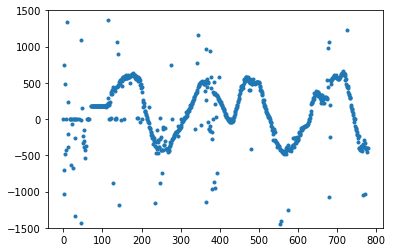

In [20]:

plt.plot(np.load("./data/tdoa_20201016/data/music_0014/" +
         "detections.npy")[:, 1, 11], '.')
plt.ylim([-1500, 1500])
